# CZ4042 Neural Networks & Deep Learning: Assignment 1 
## PART B: Regression Problem 

---

**Name:** Datta Anusha 

**Matricultation Number:** U1822948G

**Email:** anusha007@e.ntu.edu.sg

---

**DATASET:** publicly available data on HDB flat prices in Singapore, obtained from data.gov.sg on 5th August 2021

**AIM:**

(i) perform retrospective prediction of HDB housing prices (resale_price),

(ii) identify the most important features that contributed to the prediction

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
!pip install tensorflow_addons

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as pyplot
import math

In [4]:
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [5]:
df.dtypes

month                       int64
year                        int64
full_address               object
nearest_stn                object
dist_to_nearest_stn       float64
dist_to_dhoby             float64
degree_centrality         float64
eigenvector_centrality    float64
flat_model_type            object
remaining_lease_years     float64
floor_area_sqm            float64
storey_range               object
resale_price              float64
dtype: object

In [6]:
# Helper Functions 

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

### **QUESTION 1:**

a) Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets
by using entries from year 2020 and before as training data (with the
remaining data from year 2021 used as test data).
Why is this done instead of random train/test splits? 

As stated in the problem above, the focus is on retrospective prediction of HDB housing prices, instead of performing time series analysis using models (e.g. Recurrent Neural Networks) that can model sequential data. 

Also, the problem states that HBD proces have been progressively rising over the past few years. Since we do not make use of temporal information to predict future prices, we split by using entries before and after 2020 instead of random subsampling. 

In [7]:
# Split data (Train data: up to year 2020; Test data: for year 2021)
train_dataframe = df[df['year'] <= 2020] 
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

b) Following this tutorial, design a 2-layer feedforward neural network
consisting of an input layer, a hidden layer (10 neurons, ReLU as activation
function), and a linear output layer. One-hot encoding should be applied
to categorical features and numeric features are standardised. After
encoding / standardisation, the input features should be concatenated. 



**Total Features Count:** 9

**Numeric features:** dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm

**Categorical features:** month, flat_model_type, storey_range

We will use Keras preprocessing layers to normalize the numerical features and vectorize the categorical ones.

In [8]:
# One-hot encoding for categorical variables:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Normalization for Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_inputs = [
      month,
      flat_model_type,
      storey_range,
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years,
      floor_area_sqm,       
]

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

In [9]:
# Define Model Parameters

num_neurons = 10
epochs = 100
batch_size = 128

# Learning Rate
learning_rate= 0.05
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Loss/Cost function
loss = tf.keras.losses.MeanSquaredError()

# Metrics
r_square = tfa.metrics.RSquare(dtype=tf.float32,y_shape=(1,))
metrics = [r_square]

print("Model Parameters set")

Model Parameters set


In [10]:
# Create Model
x = layers.Dense(num_neurons, 
                 activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model = keras.Model(all_inputs, output)

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics) 

In [11]:
# Define CallBack to save best model only
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    '/tmp/checkpoint', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, save_freq='epoch')

In [12]:
model.layers

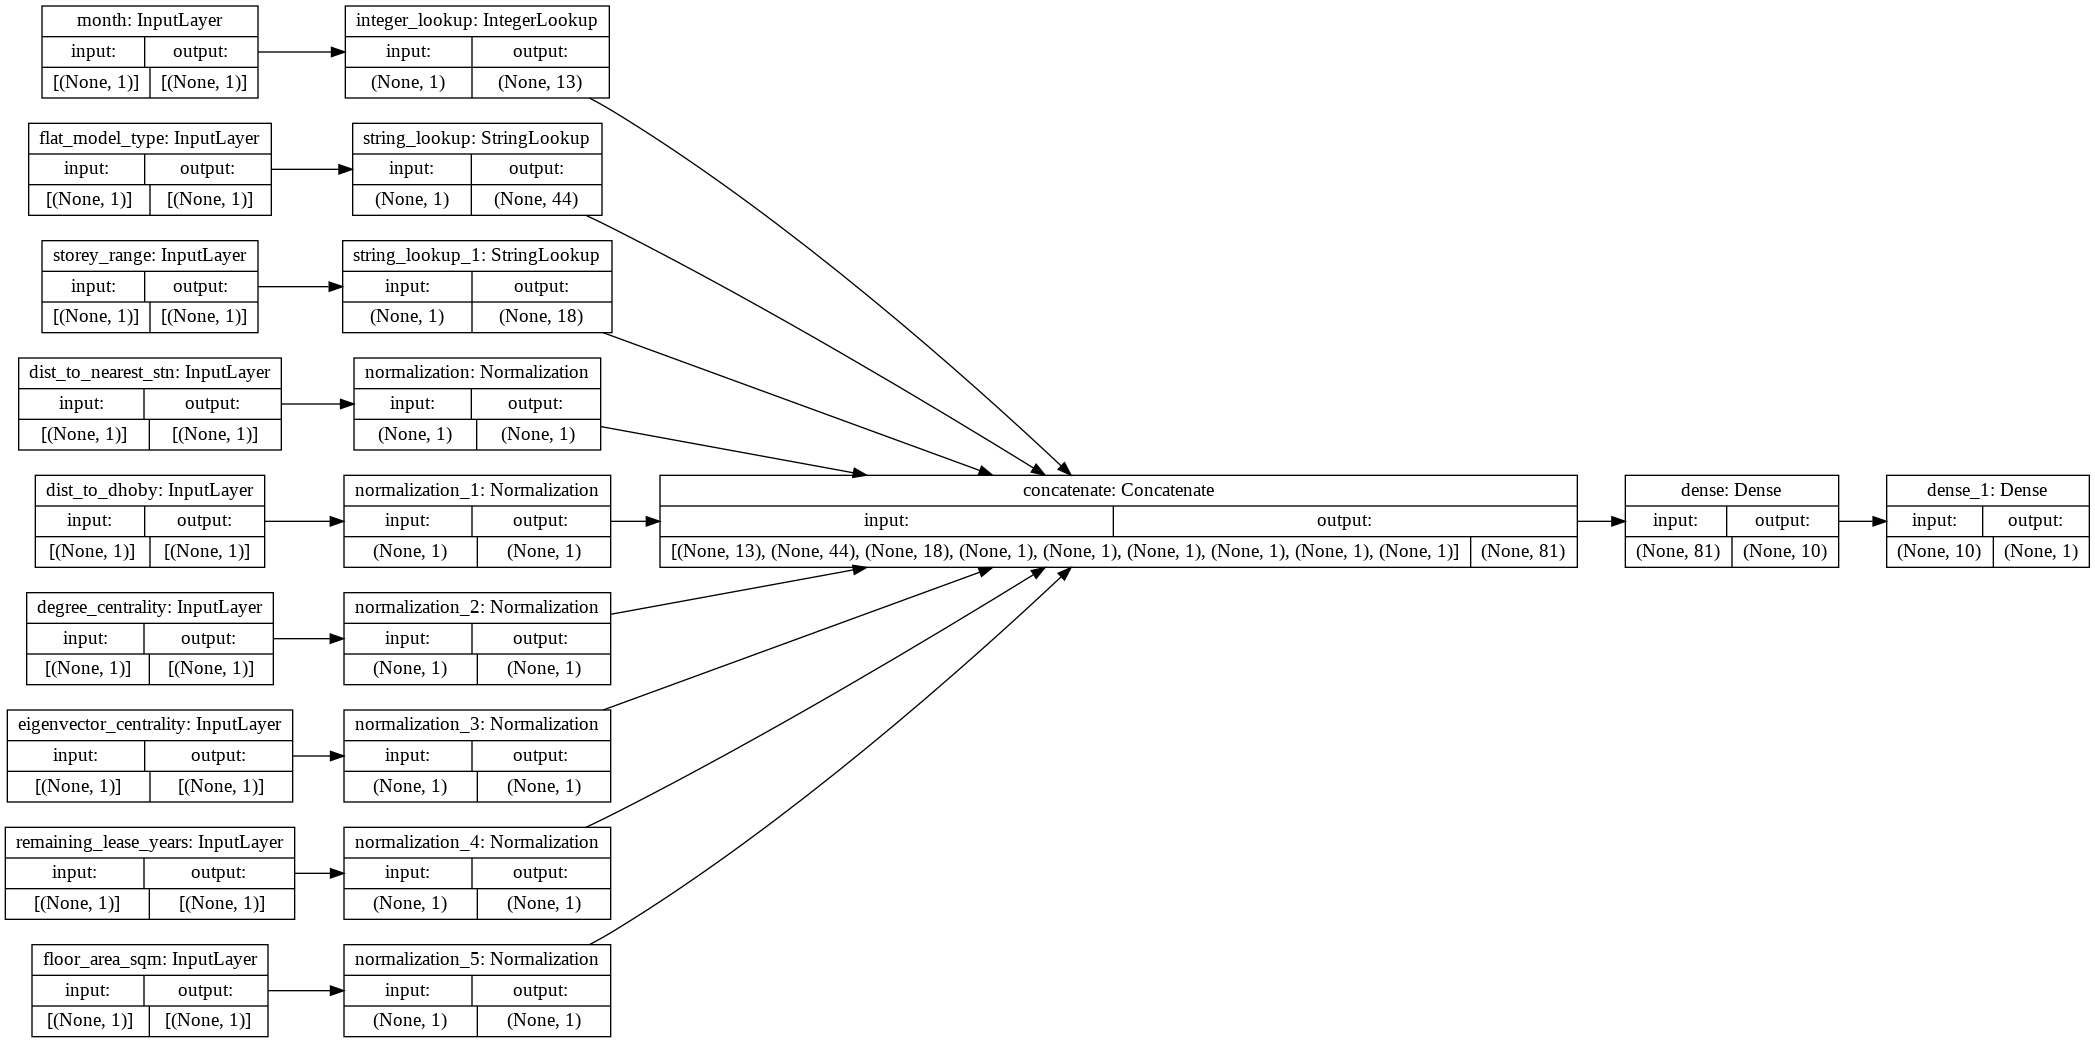

In [13]:
# Visualise model architecture
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

c) On the training data, train the model for 100 epochs using mini-batch
gradient descent with batch size = 128, Use ‘adam’ optimiser with a
learning rate of 𝛼 = 0.05 and mean square error as cost function.
(Tip: Use smaller epochs while you’re still debugging. On Google
Colaboratory, 100 epochs take around 10 minutes even without GPU.)

In [14]:
history = model.fit(train_ds, 
                    epochs= epochs, 
                    batch_size= batch_size, 
                    verbose = 2,
                    callbacks = [model_checkpoint_callback],
                    validation_data=val_ds) 

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 189632856064.0000 - r_square: -6.9731e+00 - val_loss: 175632433152.0000 - val_r_square: -5.7260e+00
Epoch 2/100
683/683 - 3s - loss: 69289795584.0000 - r_square: -1.9133e+00 - val_loss: 40588144640.0000 - val_r_square: -5.5436e-01
Epoch 3/100
683/683 - 2s - loss: 10976581632.0000 - r_square: 0.5385 - val_loss: 11043729408.0000 - val_r_square: 0.5771
Epoch 4/100
683/683 - 2s - loss: 5546234368.0000 - r_square: 0.7668 - val_loss: 8589943808.0000 - val_r_square: 0.6710
Epoch 5/100
683/683 - 2s - loss: 4997148160.0000 - r_square: 0.7899 - val_loss: 7986380288.0000 - val_r_square: 0.6942
Epoch 6/100
683/683 - 2s - loss: 4630482944.0000 - r_square: 0.8053 - val_loss: 7683659776.0000 - val_r_square: 0.7057
Epoch 7/100
683/683 - 3s - loss: 4365612032.0000 - r_square: 0.8164 - val_loss: 7284979712.0000 - val_r_square: 0.7210
Epoch 8/100
683/683 - 2s - loss: 4175544064.0000 - r_square: 0.8244 - val_loss: 7109855232.0000 - val_r_square: 0.7277
Epoch 9/100
683/683 - 2s - loss:

d) Plot the train and test root mean square errors (RMSE) against epochs
(Tip: skip the first few epochs, else the plot gets dominated by them).

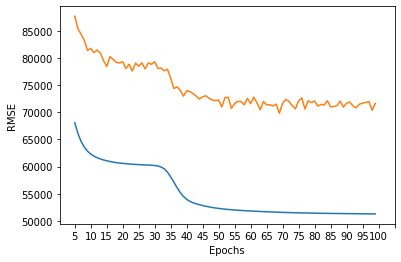

In [15]:
pyplot.plot(np.sqrt(history.history['loss'][5:]), label="Train RMSE") 
pyplot.plot(np.sqrt(history.history['val_loss'][5:]), label="Test RMSE")

pyplot.xlabel("Epochs")
pyplot.ylabel("RMSE")
pyplot.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90 , 95, 100],[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90 , 95, 100])

pyplot.show()

e) State the epoch with the lowest test error. State the test R2 value at
that epoch. (Hint: Check the output returned by model.fit(). Use a
custom metric for computing R2
.) 

In [16]:
print("Model History keys: ", history.history.keys())
print("Model History object: ", history.history)

Model History keys:  dict_keys(['loss', 'r_square', 'val_loss', 'val_r_square'])
Model History object:  {'loss': [189632856064.0, 69289795584.0, 10976581632.0, 5546234368.0, 4997148160.0, 4630482944.0, 4365612032.0, 4175544064.0, 4041911808.0, 3947340032.0, 3880764672.0, 3833285120.0, 3796926464.0, 3769359616.0, 3746755072.0, 3727394304.0, 3712101120.0, 3698636544.0, 3686805248.0, 3677737472.0, 3670280192.0, 3663147264.0, 3656303872.0, 3651208192.0, 3646713600.0, 3642714880.0, 3638170112.0, 3634992896.0, 3631947520.0, 3627903488.0, 3622315520.0, 3612006400.0, 3589592320.0, 3549354752.0, 3477192960.0, 3375851776.0, 3262527744.0, 3148881152.0, 3048080640.0, 2969217792.0, 2912560640.0, 2872601856.0, 2844143104.0, 2823554304.0, 2806336256.0, 2789629952.0, 2775931136.0, 2764194560.0, 2752249088.0, 2742737408.0, 2735081472.0, 2727140608.0, 2720471040.0, 2714248192.0, 2708786688.0, 2703949824.0, 2700220416.0, 2695624704.0, 2692040960.0, 2688082944.0, 2685412096.0, 2681968896.0, 2678217472.0, 

In [17]:
# Extract Test MSE and Test R-square values
val_mse_values = history.history['val_loss'] # loss function: MSE 
val_r_square_values = history.history['val_r_square']

# Find epoch for minimum MSE
min_val_loss = min(val_mse_values)
min_val_loss_epoch = val_mse_values.index(min_val_loss)

# Find Test R-square value at epoch
val_r_square_at_min_loss_epoch = val_r_square_values[min_val_loss_epoch]

# Print Results
print('Epoch for Lowest Test Error:', min_val_loss_epoch + 1)
print('Lowest Test Error Value:', min_val_loss)
print('Test R-Square value at Epoch', min_val_loss_epoch + 1 ,':', val_r_square_at_min_loss_epoch)

Epoch for Lowest Test Error: 70
Lowest Test Error Value: 4872493056.0
Test R-Square value at Epoch 70 : 0.8134035468101501


f) Using the model from that best epoch, plot the predicted values and
target values for a batch of 128 test samples. (Hint: Use a callback to
restore the best model weights. Find out how to retrieve a batch from
tf.BatchDataset. A scatter plot will suffice.)

In [18]:
# Restore best model weights
model.load_weights('/tmp/checkpoint')

In [19]:
x_new_batch=tf.data.Dataset.take(train_ds,1)

In [20]:
# Predicted Y values (Y_pred)
y_pred = model.predict(x_new_batch)

# Ground truth Y values (Y_true)
y_true=list(x_new_batch.as_numpy_iterator())

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


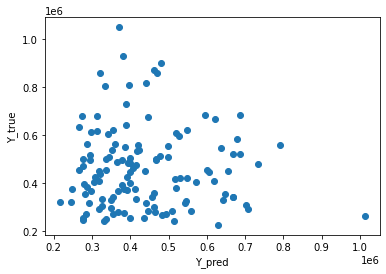

In [23]:
# Plot (predicted values, ground truth labels) 
pyplot.scatter(y_pred, y_true[0][1])
pyplot.xlabel('Y_pred')
pyplot.ylabel('Y_true') 
pyplot.show()

From the plot above we can see that visualise the predicitive accuracy of the model. If the model performed with 100% accuracy, the plotted data points (predicted values, ground truth labels) would fall in a straight line at a slope of 1. 

### **QUESTION 2:** 

a) Add an Embedding layer with output_dim = floor(num_categories/2)
after the one-hot embeddings for categorical variables. (Hint: Use the
tf.keras.layers.Embedding() later. Read the documentation carefully to
ensure that you define the correct function parameters)

In the previous case, IntegerLookup was being used to one-hot encode the categorical features. Now since we are using embedding, we use IntegerLookup to transform features to a format the Embedding layer can accept by setting output_mode = "int" instead of "binary". 

In [24]:
def encode_categorical_feature_embedding(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # set output_mode = "int" instead of "binary"

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

Add 1 embedding layer for each categorical feature.
However, only 1 concatenate layer required. 

In [25]:
# Compute number of categories for each feature
# Add 1 since range is not inclusive, e.g. month [0,12)
month_categories = len(df['month'].unique()) + 1
flat_model_categories = len(df['flat_model_type'].unique()) + 1
storey_range_categories = len(df['storey_range'].unique()) + 1

# Encode features to be passed to Embedding Layer
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature_embedding(month, "month", train_ds, False)

flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature_embedding(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature_embedding(storey_range, "storey_range", train_ds, True)

# Apply Embedding Layer
month_embedded = layers.Embedding(input_dim=month_categories, 
                                  output_dim=math.floor(month_categories/2), 
                                  input_length=2)(month_encoded)

flat_model_type_embedded = layers.Embedding(input_dim=flat_model_categories, 
                                            output_dim=math.floor(flat_model_categories/2), 
                                            input_length=2)(flat_model_type_encoded)
                                            
storey_range_embedded = layers.Embedding(input_dim=storey_range_categories, 
                                         output_dim=math.floor(storey_range_categories/2), 
                                         input_length=2)(storey_range_encoded)


b) The Embedding layer produces a 2D output (3D, including batch),
which cannot be concatenated with the other features. Look through
the Keras layers API to determine which layer to add in, such that all
the features can be concatenated. Train the model using the same
configuration as Q1. (Tip: A full run takes ~15 mins, so reduce epochs
when debugging your code but remember to switch it back to 100.)

In [26]:
# Flatten Embedding Layers to concatenate
month_embedded_flattened = layers.Flatten()(layers.Embedding(input_dim=13, 
                                                             output_dim = math.floor(month_categories/2), 
                                                             input_length=2)(month_encoded))

flat_model_type_embedded_flattened = layers.Flatten()(layers.Embedding(input_dim=44,
                                                                       output_dim = math.floor(flat_model_categories/2), 
                                                                       input_length=2)(flat_model_type_encoded))

storey_range_embedded_flattened = layers.Flatten()(layers.Embedding(input_dim=18,
                                                                    output_dim = math.floor(storey_range_categories/2), 
                                                                    input_length=2)(storey_range_encoded))

inputs = [
      month,
      flat_model_type,
      storey_range,
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years,
      floor_area_sqm,       
]

# Concatenate Features 
# Only 1 concatenate layer required
features_embedded = layers.concatenate(
    [
        month_embedded_flattened,
        flat_model_type_embedded_flattened,
        storey_range_embedded_flattened,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

In [27]:
# Define Model Parameters

num_neurons = 10
epochs = 100
batch_size = 128

# Learning Rate
learning_rate= 0.05
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Loss/Cost function
loss = tf.keras.losses.MeanSquaredError()

# Metrics
r_square = tfa.metrics.RSquare(dtype=tf.float32,y_shape=(1,))
metrics = [r_square]

print("Model Parameters set")

Model Parameters set


In [28]:
# Create Model
layer2 = layers.Dense(num_neurons, activation="relu")(features_embedded)
output = layers.Dense(1, activation="linear")(layer2)

embedded_model = keras.Model(inputs, output)

embedded_model.compile(optimizer=optimizer, 
                       loss=loss, 
                       metrics=metrics)

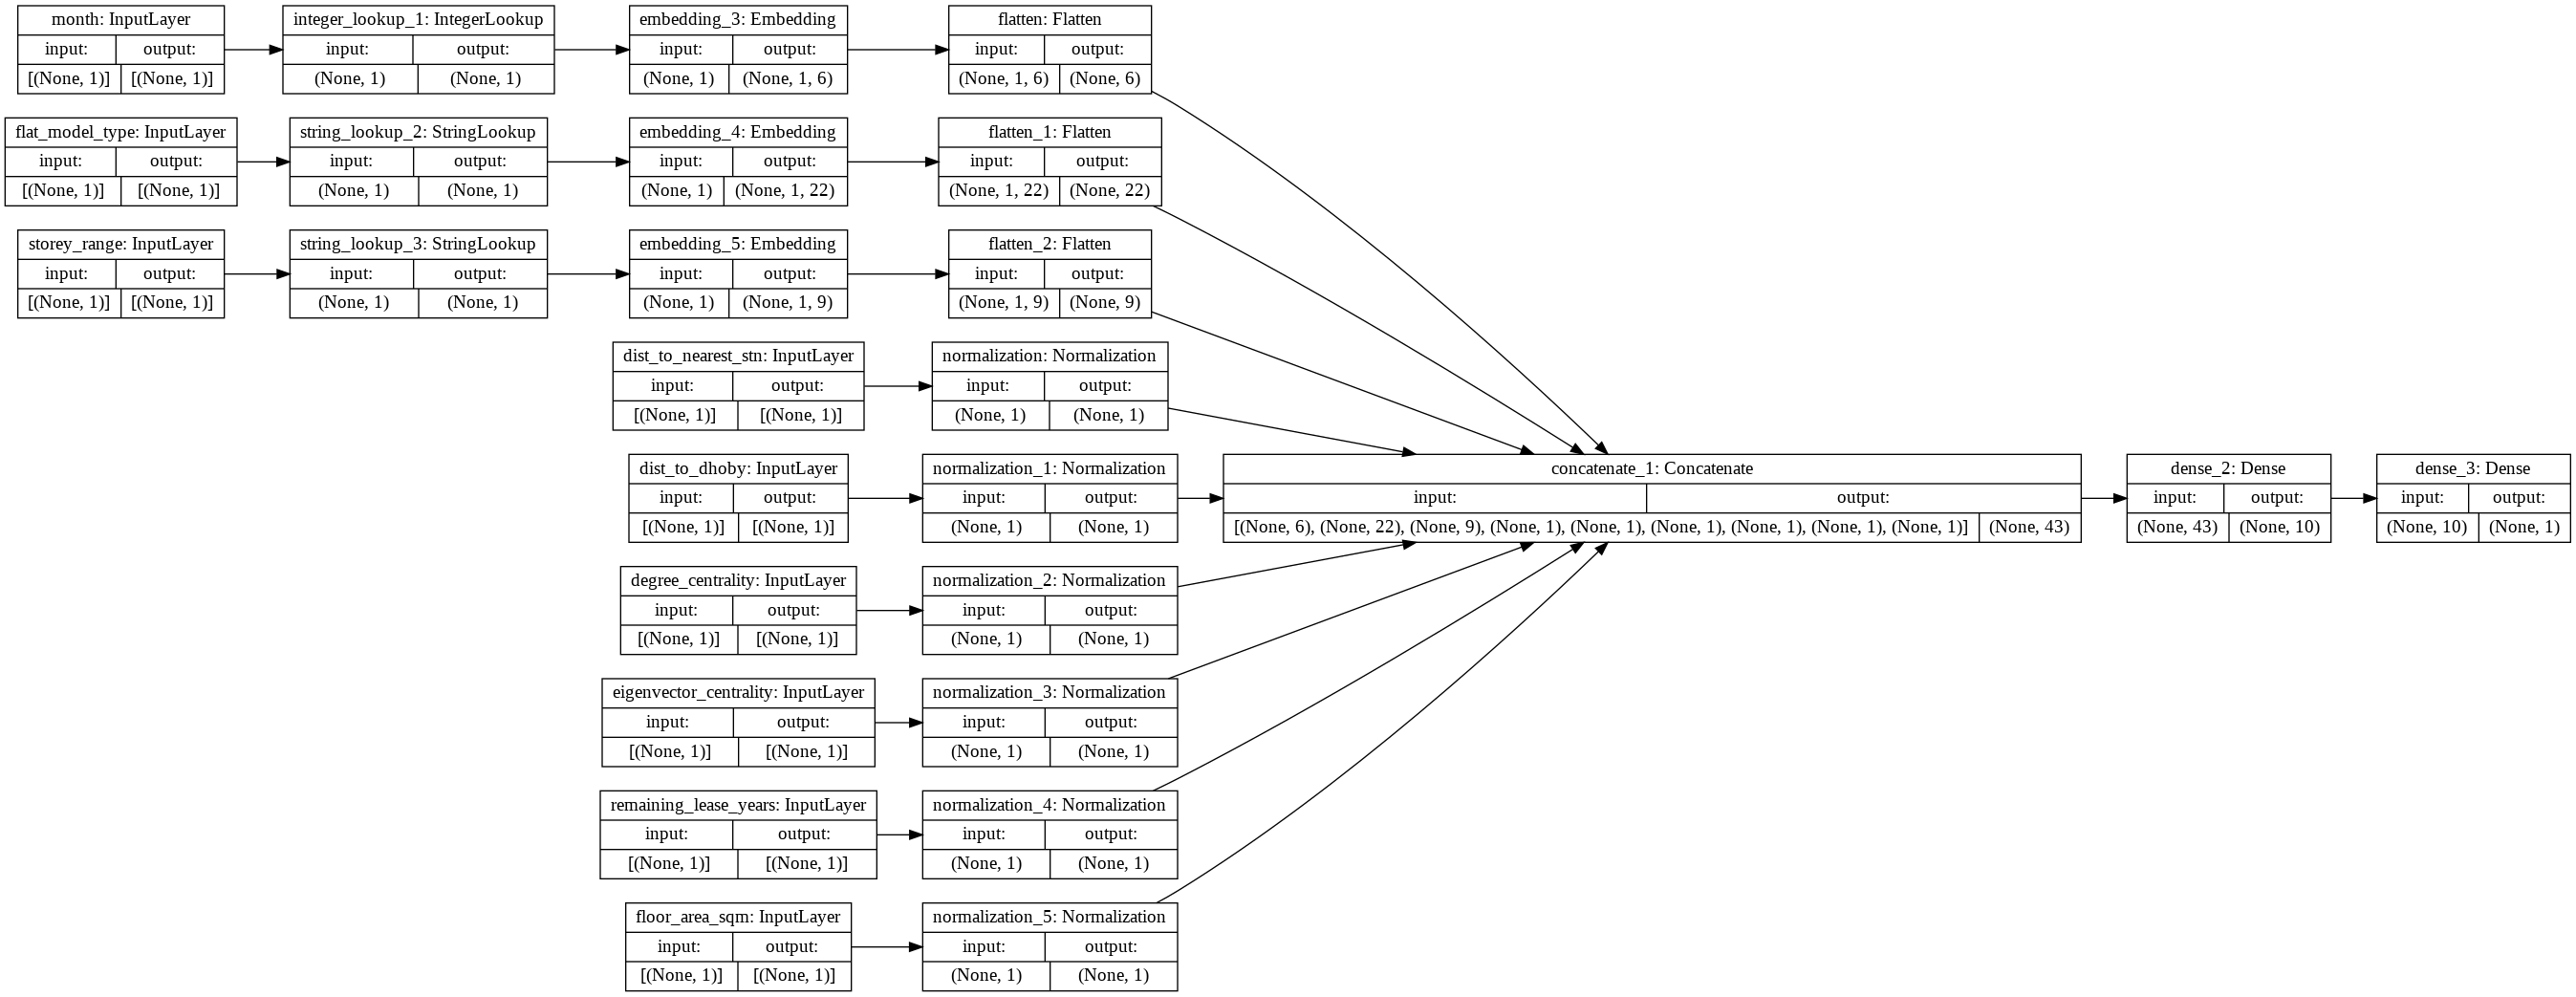

In [29]:
# Visualise model architecture
keras.utils.plot_model(embedded_model, show_shapes=True, rankdir="LR")

In [30]:
history = embedded_model.fit(train_ds, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             verbose=2,
                             validation_data=val_ds) 

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 50187210752.0000 - r_square: -1.1101e+00 - val_loss: 12861436928.0000 - val_r_square: 0.5075
Epoch 2/100
683/683 - 2s - loss: 8447997440.0000 - r_square: 0.6448 - val_loss: 10655450112.0000 - val_r_square: 0.5919
Epoch 3/100
683/683 - 2s - loss: 7444551168.0000 - r_square: 0.6870 - val_loss: 9285469184.0000 - val_r_square: 0.6444
Epoch 4/100
683/683 - 3s - loss: 6791169024.0000 - r_square: 0.7145 - val_loss: 8803481600.0000 - val_r_square: 0.6629
Epoch 5/100
683/683 - 3s - loss: 6167241728.0000 - r_square: 0.7407 - val_loss: 8629781504.0000 - val_r_square: 0.6695
Epoch 6/100
683/683 - 2s - loss: 5585618432.0000 - r_square: 0.7651 - val_loss: 7621121024.0000 - val_r_square: 0.7081
Epoch 7/100
683/683 - 3s - loss: 5135729664.0000 - r_square: 0.7841 - val_loss: 7272786944.0000 - val_r_square: 0.7215
Epoch 8/100
683/683 - 3s - loss: 4809725952.0000 - r_square: 0.7978 - val_loss: 6907408896.0000 - val_r_square: 0.7355
Epoch 9/100
683/683 - 2s - loss: 4558201856.0000 - r

c) Compare the current model performances in terms of both test RMSE
and test R
2 with the model from Q1 (at their own best epochs) and
suggest a possible reason for the difference in performance. 

In [31]:
# Extract Test MSE and Test R-square values
val_mse_values = history.history['val_loss'] # loss function: MSE 
val_r_square_values = history.history['val_r_square']

# Find epoch for minimum MSE
min_val_loss = min(val_mse_values)
min_val_loss_epoch = val_mse_values.index(min_val_loss)

# Find Test R-square value at epoch
val_r_square_at_min_loss_epoch = val_r_square_values[min_val_loss_epoch]

# Print Results
print('Epoch for Lowest Test Error:', min_val_loss_epoch + 1)
print('Lowest Test Error Value:', min_val_loss)
print('Test R-Square value at Epoch', min_val_loss_epoch + 1 ,':', val_r_square_at_min_loss_epoch)

Epoch for Lowest Test Error: 31
Lowest Test Error Value: 5379423232.0
Test R-Square value at Epoch 31 : 0.7939907312393188


It may be observed that there is an decrease in performance (increase in test error and decrease in R-square value). 

Since an Embedding layer was used for the categorical variables instead of one-hot encoding, this is an unexpected resilt. This is because such an approach utilises the ability of neural networks to learn richer representations of the data and encode more meaningful relationships – an edge it has over traditional ML models. 

However, it must be noted that it is not a guarantee that the model using embeddings will do better than the previous model which used one-hot encodings. A further exploration of the models may reveal under/over-parametereisation, which shall be able to explain these results. Hence, we can use that information to tune the models and obtain a higher performing model. 

### **QUESTION 3:** 

Recursive feature elimination (RFE) is a feature selection method that removes
unnecessary features from the inputs, one by one. It can also shed some insights on how much each
feature contributes to the prediction task.

a) Continue with the model architecture you have after Q2. Via a callback,
introduce early stopping (based on val_loss, with patience of 10 epochs) to
the model.

In [32]:
# Define CallBack for early stopping
def early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=10)

In [33]:
history = embedded_model.fit(train_ds, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             verbose=2,
                             callbacks= [early_stopping()],
                             validation_data=val_ds) 

Epoch 1/100
683/683 - 3s - loss: 3642030080.0000 - r_square: 0.8469 - val_loss: 6210176512.0000 - val_r_square: 0.7622
Epoch 2/100
683/683 - 3s - loss: 3640924160.0000 - r_square: 0.8469 - val_loss: 6232992256.0000 - val_r_square: 0.7613
Epoch 3/100
683/683 - 2s - loss: 3641579008.0000 - r_square: 0.8469 - val_loss: 6306866176.0000 - val_r_square: 0.7585
Epoch 4/100
683/683 - 2s - loss: 3641089280.0000 - r_square: 0.8469 - val_loss: 6222566912.0000 - val_r_square: 0.7617
Epoch 5/100
683/683 - 2s - loss: 3640530944.0000 - r_square: 0.8469 - val_loss: 6935338496.0000 - val_r_square: 0.7344
Epoch 6/100
683/683 - 3s - loss: 3638006528.0000 - r_square: 0.8470 - val_loss: 5717802496.0000 - val_r_square: 0.7810
Epoch 7/100
683/683 - 2s - loss: 3640811520.0000 - r_square: 0.8469 - val_loss: 6875949056.0000 - val_r_square: 0.7367
Epoch 8/100
683/683 - 2s - loss: 3639363840.0000 - r_square: 0.8470 - val_loss: 6105044992.0000 - val_r_square: 0.7662
Epoch 9/100
683/683 - 3s - loss: 3642380032.0000

In [34]:
all_features_history = history

b) Start by removing one input feature whose removal leads to the minimum
drop (or maximum improvement) in performance5
. Repeat the procedure
recursively on the reduced input set until the optimal number of input
features is reached6
. Remember to remove features one at a time. Record
the RMSE of each experiment neatly in a table (i.e., without feature 1,
without feature 2, etc.). (Hint: Use a binary vector mask to keep track of the
features. When you remove a feature, you do not have to repeatedly remove
the initialisation of the input layers for each feature. Just choose which to
include when you concatenate the features. Make sure to clear the session
at every iteration of feature elimination. A full run take ~2hrs.) 

The idea of Recursive Feature Elimination (RFE) is that a subset of features may perform better than entire feature set. Hence, we attempt to train different models with different subset of features and evaluate the performances, to find the optimal model with optimal number of features. 

**RFE Pseudo-code:**

Start with all k features, train model for all k features  

1. [Base Case] Check if count of remaining features > 1, else break 
2. Train k models, each with (k-1) features by dropping and restoring features one by one 
3. Select best model of the k models with (k-1) features that leads to highest performance improvement (lowest MSE/highest R-square) 
4. [Base Case] If no improvement in performance after dropping feature (Best Model Performance <= Previous Best Model Performance), break
5. Drop the corresponding feature of best selected model 
6. [Recursive Step] Back to 1 with (k-1) features 

Note: In this case, 100 epochs assigned for training each model, no early stopping used

In [35]:
# RFE model trained independently with selected subset of input_features
def train_model(input_features, current_number_of_features, model_inputs):

  # Model Parameters
  epochs = 100
  batch_size = 128

  # Learning Rate
  learning_rate= 0.05
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  # Loss/Cost function
  loss = tf.keras.losses.MeanSquaredError()

  # Metrics
  r_square = tfa.metrics.RSquare(dtype=tf.float32,y_shape=(1,))
  metrics = [r_square]

  # Create Model
  layer2 = layers.Dense(current_number_of_features, 
                        activation="relu")(input_features)
  output = layers.Dense(1, activation="linear")(layer2)

  model = keras.Model(model_inputs, output)

  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)
  
  # Train Model 
  history = model.fit(train_ds,
                      verbose=2,
                      epochs=epochs,
                      use_multiprocessing=False,
                      callbacks= [early_stopping()],
                      batch_size = batch_size,
                      validation_data=val_ds)
  
  # Return Model History 
  return history

In [36]:
# Initialise Variables
features_embedded_list = [
        month_embedded_flattened,
        flat_model_type_embedded_flattened,
        storey_range_embedded_flattened,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]

# Binary Mask (1: feature exists, 0: feature removed)
feature_mask = [1] * 9 

# {key: no. of features k, value: history object of best model for k features}
model_mse = {9: all_features_history} 

# Record indices of dropped features
removed_features = []

In [37]:
def RFE(feature_count):

  model_mse_k_features = {} # temp MSE table for k experiements
  best_model_index = -1 # best model index for k experiments, can range from 1 to 9 
  best_mse = math.inf # initialise best mse for k experiments
  
  # Base case 1: only 1 feature remaining
  if feature_count == 1:
    return model_mse['2']

  # k experiments to determine best model for k features
  for i in range(0, 9):

    # If feature already dropped, then continue
    if feature_mask[i] == 0: 
      continue

    # Temporarily drop feature to train model for remaining k features
    print()
    print("Removing feature: ", i+1)
    feature_mask[i] = 0
    
    # Define input features and model inputs   
    input_features = layers.concatenate([features_embedded_list[i] for i in range(len(feature_mask)) if feature_mask[i]])
    model_inputs = [inputs[i] for i in range(len(feature_mask)) if feature_mask[i]]

    # Train model with dropped feature
    history = train_model(input_features, feature_count-1, model_inputs)

    # Store history for model with k features, with feature i dropped 
    model_mse_k_features[i + 1] = history 

    # Update best model for k features ('loss': MSE)
    if history.history['val_loss'][-1] <= best_mse:
      best_mse = min(history.history['val_loss'])
      best_model_index = i

    # Restore feature for next experiment 
    feature_mask[i] = 1 

  print()
  print("Completed ", feature_count-1, "experiements of training models for ", feature_count - 1," features")

  # Drop least important feature (which leads to lowest model MSE after getting dropped)
  feature_mask[best_model_index] = 0 
  
  print()
  print("Feature removed: ", best_model_index + 1)

  # Save MSE of model after dropped least important feature
  model_mse[feature_count-1] = model_mse_k_features[best_model_index + 1]
  removed_features.append(best_model_index)

  # Base case 2: Model Performance <= Previous Model Performance (no improve in performance after dropping feature)
  if min(model_mse[feature_count - 1].history['val_loss']) >= min(model_mse[feature_count].history['val_loss']):
    return model_mse[feature_count]

  RFE(feature_count-1)

In [38]:
# Initialise RFE parameter 
feature_count = 9 # start with existing current number of features 

RFE(feature_count)


Removing feature:  1
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 45156319232.0000 - r_square: -8.9860e-01 - val_loss: 10696318976.0000 - val_r_square: 0.5904
Epoch 2/100
683/683 - 2s - loss: 8150714880.0000 - r_square: 0.6573 - val_loss: 9969920000.0000 - val_r_square: 0.6182
Epoch 3/100
683/683 - 2s - loss: 7539315200.0000 - r_square: 0.6830 - val_loss: 9055220736.0000 - val_r_square: 0.6532
Epoch 4/100
683/683 - 2s - loss: 6997710848.0000 - r_square: 0.7058 - val_loss: 9273366528.0000 - val_r_square: 0.6449
Epoch 5/100
683/683 - 2s - loss: 6406544384.0000 - r_square: 0.7306 - val_loss: 8555025920.0000 - val_r_square: 0.6724
Epoch 6/100
683/683 - 2s - loss: 5813753856.0000 - r_square: 0.7556 - val_loss: 7611578368.0000 - val_r_square: 0.7085
Epoch 7/100
683/683 - 2s - loss: 5316796416.0000 - r_square: 0.7765 - val_loss: 7028341248.0000 - val_r_square: 0.7308
Epoch 8/100
683/683 - 2s - loss: 4956956672.0000 - r_square: 0.7916 - val_loss: 6779365376.0000 - val_r_square: 0.7404
Epoch 9/100
683/683 - 2s - loss: 4690183680.0000 - r_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 65861398528.0000 - r_square: -1.7692e+00 - val_loss: 25647335424.0000 - val_r_square: 0.0178
Epoch 2/100
683/683 - 2s - loss: 19595720704.0000 - r_square: 0.1761 - val_loss: 24213102592.0000 - val_r_square: 0.0727
Epoch 3/100
683/683 - 2s - loss: 18579048448.0000 - r_square: 0.2188 - val_loss: 23546632192.0000 - val_r_square: 0.0983
Epoch 4/100
683/683 - 2s - loss: 17728049152.0000 - r_square: 0.2546 - val_loss: 22684760064.0000 - val_r_square: 0.1313
Epoch 5/100
683/683 - 2s - loss: 16750865408.0000 - r_square: 0.2957 - val_loss: 21542395904.0000 - val_r_square: 0.1750
Epoch 6/100
683/683 - 2s - loss: 15478957056.0000 - r_square: 0.3492 - val_loss: 19655006208.0000 - val_r_square: 0.2473
Epoch 7/100
683/683 - 2s - loss: 13838918656.0000 - r_square: 0.4181 - val_loss: 17829251072.0000 - val_r_square: 0.3172
Epoch 8/100
683/683 - 2s - loss: 11906393088.0000 - r_square: 0.4994 - val_loss: 15481817088.0000 - val_r_square: 0.4071
Epoch 9/100
683/683 - 2s - loss: 988185

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 219570323456.0000 - r_square: -8.2320e+00 - val_loss: 277021163520.0000 - val_r_square: -9.6087e+00
Epoch 2/100
683/683 - 2s - loss: 219539881984.0000 - r_square: -8.2306e+00 - val_loss: 276987019264.0000 - val_r_square: -9.6074e+00
Epoch 3/100
683/683 - 2s - loss: 219509669888.0000 - r_square: -8.2293e+00 - val_loss: 276952809472.0000 - val_r_square: -9.6062e+00
Epoch 4/100
683/683 - 2s - loss: 219479605248.0000 - r_square: -8.2281e+00 - val_loss: 276918599680.0000 - val_r_square: -9.6048e+00
Epoch 5/100
683/683 - 2s - loss: 219449245696.0000 - r_square: -8.2268e+00 - val_loss: 276884422656.0000 - val_r_square: -9.6035e+00
Epoch 6/100
683/683 - 2s - loss: 219419099136.0000 - r_square: -8.2256e+00 - val_loss: 276850278400.0000 - val_r_square: -9.6022e+00
Epoch 7/100
683/683 - 2s - loss: 219388887040.0000 - r_square: -8.2242e+00 - val_loss: 276816166912.0000 - val_r_square: -9.6010e+00
Epoch 8/100
683/683 - 2s - loss: 219358822400.0000 - r_square: -8.2229e+00 - val_

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 55885844480.0000 - r_square: -1.3497e+00 - val_loss: 12638055424.0000 - val_r_square: 0.5160
Epoch 2/100
683/683 - 2s - loss: 9306205184.0000 - r_square: 0.6087 - val_loss: 11272588288.0000 - val_r_square: 0.5683
Epoch 3/100
683/683 - 2s - loss: 8657248256.0000 - r_square: 0.6360 - val_loss: 11257255936.0000 - val_r_square: 0.5689
Epoch 4/100
683/683 - 2s - loss: 8368730624.0000 - r_square: 0.6481 - val_loss: 10855198720.0000 - val_r_square: 0.5843
Epoch 5/100
683/683 - 2s - loss: 8179030528.0000 - r_square: 0.6561 - val_loss: 10406421504.0000 - val_r_square: 0.6015
Epoch 6/100
683/683 - 2s - loss: 8006775296.0000 - r_square: 0.6634 - val_loss: 10228606976.0000 - val_r_square: 0.6083
Epoch 7/100
683/683 - 2s - loss: 7813417984.0000 - r_square: 0.6715 - val_loss: 8999943168.0000 - val_r_square: 0.6553
Epoch 8/100
683/683 - 2s - loss: 7605240832.0000 - r_square: 0.6802 - val_loss: 10019226624.0000 - val_r_square: 0.6163
Epoch 9/100
683/683 - 2s - loss: 7354493440.000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 33466374144.0000 - r_square: -4.0712e-01 - val_loss: 11263768576.0000 - val_r_square: 0.5686
Epoch 2/100
683/683 - 2s - loss: 8578806272.0000 - r_square: 0.6393 - val_loss: 11502170112.0000 - val_r_square: 0.5595
Epoch 3/100
683/683 - 3s - loss: 8302057984.0000 - r_square: 0.6509 - val_loss: 10818766848.0000 - val_r_square: 0.5857
Epoch 4/100
683/683 - 2s - loss: 8084252672.0000 - r_square: 0.6601 - val_loss: 10134693888.0000 - val_r_square: 0.6119
Epoch 5/100
683/683 - 2s - loss: 7845886464.0000 - r_square: 0.6701 - val_loss: 9385474048.0000 - val_r_square: 0.6406
Epoch 6/100
683/683 - 2s - loss: 7577712128.0000 - r_square: 0.6814 - val_loss: 10286145536.0000 - val_r_square: 0.6061
Epoch 7/100
683/683 - 2s - loss: 7271881728.0000 - r_square: 0.6942 - val_loss: 9312260096.0000 - val_r_square: 0.6434
Epoch 8/100
683/683 - 3s - loss: 6998454272.0000 - r_square: 0.7057 - val_loss: 9412719616.0000 - val_r_square: 0.6395
Epoch 9/100
683/683 - 2s - loss: 6814400512.0000 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 40372264960.0000 - r_square: -6.9748e-01 - val_loss: 11436925952.0000 - val_r_square: 0.5620
Epoch 2/100
683/683 - 2s - loss: 8719506432.0000 - r_square: 0.6334 - val_loss: 10990022656.0000 - val_r_square: 0.5791
Epoch 3/100
683/683 - 2s - loss: 8358238208.0000 - r_square: 0.6486 - val_loss: 10239262720.0000 - val_r_square: 0.6079
Epoch 4/100
683/683 - 2s - loss: 8097124352.0000 - r_square: 0.6596 - val_loss: 10785137664.0000 - val_r_square: 0.5870
Epoch 5/100
683/683 - 2s - loss: 7842339328.0000 - r_square: 0.6703 - val_loss: 9961351168.0000 - val_r_square: 0.6185
Epoch 6/100
683/683 - 3s - loss: 7545156096.0000 - r_square: 0.6828 - val_loss: 9510394880.0000 - val_r_square: 0.6358
Epoch 7/100
683/683 - 2s - loss: 7168539648.0000 - r_square: 0.6986 - val_loss: 9660651520.0000 - val_r_square: 0.6300
Epoch 8/100
683/683 - 2s - loss: 6713756672.0000 - r_square: 0.7177 - val_loss: 9578448896.0000 - val_r_square: 0.6332
Epoch 9/100
683/683 - 2s - loss: 6204677120.0000 -

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 31107209216.0000 - r_square: -3.0792e-01 - val_loss: 10889834496.0000 - val_r_square: 0.5830
Epoch 2/100
683/683 - 3s - loss: 8477332480.0000 - r_square: 0.6436 - val_loss: 10729679872.0000 - val_r_square: 0.5891
Epoch 3/100
683/683 - 2s - loss: 8137706496.0000 - r_square: 0.6579 - val_loss: 10049681408.0000 - val_r_square: 0.6151
Epoch 4/100
683/683 - 2s - loss: 7812907008.0000 - r_square: 0.6715 - val_loss: 9503105024.0000 - val_r_square: 0.6361
Epoch 5/100
683/683 - 2s - loss: 7403708416.0000 - r_square: 0.6887 - val_loss: 9523496960.0000 - val_r_square: 0.6353
Epoch 6/100
683/683 - 2s - loss: 6850331136.0000 - r_square: 0.7120 - val_loss: 8204504064.0000 - val_r_square: 0.6858
Epoch 7/100
683/683 - 3s - loss: 6185956352.0000 - r_square: 0.7399 - val_loss: 8290046976.0000 - val_r_square: 0.6825
Epoch 8/100
683/683 - 2s - loss: 5527714816.0000 - r_square: 0.7676 - val_loss: 7407060480.0000 - val_r_square: 0.7163
Epoch 9/100
683/683 - 2s - loss: 4992768000.0000 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 33739298816.0000 - r_square: -4.1858e-01 - val_loss: 11366637568.0000 - val_r_square: 0.5647
Epoch 2/100
683/683 - 3s - loss: 8478840832.0000 - r_square: 0.6435 - val_loss: 10713643008.0000 - val_r_square: 0.5897
Epoch 3/100
683/683 - 2s - loss: 8122967040.0000 - r_square: 0.6585 - val_loss: 10717052928.0000 - val_r_square: 0.5896
Epoch 4/100
683/683 - 2s - loss: 7807533568.0000 - r_square: 0.6717 - val_loss: 10548082688.0000 - val_r_square: 0.5961
Epoch 5/100
683/683 - 2s - loss: 7442460672.0000 - r_square: 0.6871 - val_loss: 9621390336.0000 - val_r_square: 0.6315
Epoch 6/100
683/683 - 3s - loss: 6974025728.0000 - r_square: 0.7068 - val_loss: 8627953664.0000 - val_r_square: 0.6696
Epoch 7/100
683/683 - 3s - loss: 6440378880.0000 - r_square: 0.7292 - val_loss: 9285142528.0000 - val_r_square: 0.6444
Epoch 8/100
683/683 - 2s - loss: 5933947392.0000 - r_square: 0.7505 - val_loss: 8589161984.0000 - val_r_square: 0.6711
Epoch 9/100
683/683 - 2s - loss: 5550901760.0000 -

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 31805419520.0000 - r_square: -3.3726e-01 - val_loss: 10994207744.0000 - val_r_square: 0.5790
Epoch 2/100
683/683 - 2s - loss: 8394540544.0000 - r_square: 0.6470 - val_loss: 10254543872.0000 - val_r_square: 0.6073
Epoch 3/100
683/683 - 2s - loss: 8040229888.0000 - r_square: 0.6619 - val_loss: 10028595200.0000 - val_r_square: 0.6159
Epoch 4/100
683/683 - 3s - loss: 7663711744.0000 - r_square: 0.6778 - val_loss: 9586767872.0000 - val_r_square: 0.6329
Epoch 5/100
683/683 - 3s - loss: 7182494208.0000 - r_square: 0.6980 - val_loss: 9540477952.0000 - val_r_square: 0.6346
Epoch 6/100
683/683 - 3s - loss: 6557198336.0000 - r_square: 0.7243 - val_loss: 8870493184.0000 - val_r_square: 0.6603
Epoch 7/100
683/683 - 3s - loss: 5915668992.0000 - r_square: 0.7513 - val_loss: 7556517376.0000 - val_r_square: 0.7106
Epoch 8/100
683/683 - 3s - loss: 5402605056.0000 - r_square: 0.7728 - val_loss: 7355582464.0000 - val_r_square: 0.7183
Epoch 9/100
683/683 - 2s - loss: 5059589632.0000 - 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 50266763264.0000 - r_square: -1.1135e+00 - val_loss: 11391113216.0000 - val_r_square: 0.5638
Epoch 2/100
683/683 - 2s - loss: 8818342912.0000 - r_square: 0.6292 - val_loss: 11336721408.0000 - val_r_square: 0.5659
Epoch 3/100
683/683 - 2s - loss: 8531053568.0000 - r_square: 0.6413 - val_loss: 10576385024.0000 - val_r_square: 0.5950
Epoch 4/100
683/683 - 3s - loss: 8354204672.0000 - r_square: 0.6487 - val_loss: 9888020480.0000 - val_r_square: 0.6213
Epoch 5/100
683/683 - 3s - loss: 8200816640.0000 - r_square: 0.6552 - val_loss: 10217713664.0000 - val_r_square: 0.6087
Epoch 6/100
683/683 - 2s - loss: 8046245888.0000 - r_square: 0.6617 - val_loss: 10102041600.0000 - val_r_square: 0.6131
Epoch 7/100
683/683 - 2s - loss: 7858845184.0000 - r_square: 0.6696 - val_loss: 10389888000.0000 - val_r_square: 0.6021
Epoch 8/100
683/683 - 2s - loss: 7637556736.0000 - r_square: 0.6789 - val_loss: 9544115200.0000 - val_r_square: 0.6345
Epoch 9/100
683/683 - 2s - loss: 7372251136.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 42541256704.0000 - r_square: -7.8865e-01 - val_loss: 24888580096.0000 - val_r_square: 0.0469
Epoch 2/100
683/683 - 3s - loss: 18992463872.0000 - r_square: 0.2015 - val_loss: 23577180160.0000 - val_r_square: 0.0971
Epoch 3/100
683/683 - 3s - loss: 18135744512.0000 - r_square: 0.2375 - val_loss: 22154442752.0000 - val_r_square: 0.1516
Epoch 4/100
683/683 - 2s - loss: 16876357632.0000 - r_square: 0.2904 - val_loss: 20931422208.0000 - val_r_square: 0.1984
Epoch 5/100
683/683 - 3s - loss: 14844252160.0000 - r_square: 0.3759 - val_loss: 17949448192.0000 - val_r_square: 0.3126
Epoch 6/100
683/683 - 3s - loss: 12032210944.0000 - r_square: 0.4941 - val_loss: 15000269824.0000 - val_r_square: 0.4256
Epoch 7/100
683/683 - 3s - loss: 9056755712.0000 - r_square: 0.6192 - val_loss: 12276691968.0000 - val_r_square: 0.5299
Epoch 8/100
683/683 - 3s - loss: 6711894016.0000 - r_square: 0.7178 - val_loss: 9747354624.0000 - val_r_square: 0.6267
Epoch 9/100
683/683 - 3s - loss: 530804377

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 35869999104.0000 - r_square: -5.0815e-01 - val_loss: 13524652032.0000 - val_r_square: 0.4821
Epoch 2/100
683/683 - 2s - loss: 10489716736.0000 - r_square: 0.5590 - val_loss: 13534349312.0000 - val_r_square: 0.4817
Epoch 3/100
683/683 - 2s - loss: 10108073984.0000 - r_square: 0.5750 - val_loss: 12401247232.0000 - val_r_square: 0.5251
Epoch 4/100
683/683 - 2s - loss: 9768933376.0000 - r_square: 0.5893 - val_loss: 12816093184.0000 - val_r_square: 0.5092
Epoch 5/100
683/683 - 3s - loss: 9361651712.0000 - r_square: 0.6064 - val_loss: 12495221760.0000 - val_r_square: 0.5215
Epoch 6/100
683/683 - 3s - loss: 8828041216.0000 - r_square: 0.6288 - val_loss: 11572207616.0000 - val_r_square: 0.5568
Epoch 7/100
683/683 - 3s - loss: 8132523520.0000 - r_square: 0.6581 - val_loss: 11241878528.0000 - val_r_square: 0.5695
Epoch 8/100
683/683 - 3s - loss: 7338613760.0000 - r_square: 0.6914 - val_loss: 10241717248.0000 - val_r_square: 0.6078
Epoch 9/100
683/683 - 3s - loss: 6573092352.

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 36829859840.0000 - r_square: -5.4853e-01 - val_loss: 11538604032.0000 - val_r_square: 0.5581
Epoch 2/100
683/683 - 2s - loss: 8810261504.0000 - r_square: 0.6296 - val_loss: 11003101184.0000 - val_r_square: 0.5786
Epoch 3/100
683/683 - 2s - loss: 8543915008.0000 - r_square: 0.6408 - val_loss: 10771578880.0000 - val_r_square: 0.5875
Epoch 4/100
683/683 - 3s - loss: 8389248000.0000 - r_square: 0.6473 - val_loss: 10712109056.0000 - val_r_square: 0.5898
Epoch 5/100
683/683 - 2s - loss: 8250354176.0000 - r_square: 0.6531 - val_loss: 11114164224.0000 - val_r_square: 0.5744
Epoch 6/100
683/683 - 3s - loss: 8097377280.0000 - r_square: 0.6595 - val_loss: 10598862848.0000 - val_r_square: 0.5941
Epoch 7/100
683/683 - 2s - loss: 7898642944.0000 - r_square: 0.6679 - val_loss: 10009833472.0000 - val_r_square: 0.6167
Epoch 8/100
683/683 - 3s - loss: 7653099008.0000 - r_square: 0.6782 - val_loss: 9719269376.0000 - val_r_square: 0.6278
Epoch 9/100
683/683 - 2s - loss: 7344060416.000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 30737840128.0000 - r_square: -2.9238e-01 - val_loss: 11306603520.0000 - val_r_square: 0.5670
Epoch 2/100
683/683 - 3s - loss: 8702824448.0000 - r_square: 0.6341 - val_loss: 11350805504.0000 - val_r_square: 0.5653
Epoch 3/100
683/683 - 2s - loss: 8563543040.0000 - r_square: 0.6399 - val_loss: 10811718656.0000 - val_r_square: 0.5860
Epoch 4/100
683/683 - 2s - loss: 8457666048.0000 - r_square: 0.6444 - val_loss: 10711173120.0000 - val_r_square: 0.5898
Epoch 5/100
683/683 - 3s - loss: 8354024960.0000 - r_square: 0.6488 - val_loss: 10657722368.0000 - val_r_square: 0.5919
Epoch 6/100
683/683 - 2s - loss: 8235132928.0000 - r_square: 0.6537 - val_loss: 10586569728.0000 - val_r_square: 0.5946
Epoch 7/100
683/683 - 2s - loss: 8095279616.0000 - r_square: 0.6596 - val_loss: 10694170624.0000 - val_r_square: 0.5905
Epoch 8/100
683/683 - 2s - loss: 7932986368.0000 - r_square: 0.6665 - val_loss: 10541079552.0000 - val_r_square: 0.5963
Epoch 9/100
683/683 - 3s - loss: 7765683200.00

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 34192392192.0000 - r_square: -4.3763e-01 - val_loss: 10979806208.0000 - val_r_square: 0.5795
Epoch 2/100
683/683 - 3s - loss: 8629059584.0000 - r_square: 0.6372 - val_loss: 11280868352.0000 - val_r_square: 0.5680
Epoch 3/100
683/683 - 2s - loss: 8463107584.0000 - r_square: 0.6442 - val_loss: 10783591424.0000 - val_r_square: 0.5870
Epoch 4/100
683/683 - 3s - loss: 8318688768.0000 - r_square: 0.6502 - val_loss: 10658932736.0000 - val_r_square: 0.5918
Epoch 5/100
683/683 - 2s - loss: 8157706752.0000 - r_square: 0.6570 - val_loss: 9950639104.0000 - val_r_square: 0.6189
Epoch 6/100
683/683 - 3s - loss: 7964324864.0000 - r_square: 0.6651 - val_loss: 11112426496.0000 - val_r_square: 0.5744
Epoch 7/100
683/683 - 2s - loss: 7702141440.0000 - r_square: 0.6762 - val_loss: 9956074496.0000 - val_r_square: 0.6187
Epoch 8/100
683/683 - 2s - loss: 7361530880.0000 - r_square: 0.6905 - val_loss: 9915771904.0000 - val_r_square: 0.6203
Epoch 9/100
683/683 - 3s - loss: 6926491648.0000 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 3s - loss: 29577195520.0000 - r_square: -2.4356e-01 - val_loss: 10911327232.0000 - val_r_square: 0.5821
Epoch 2/100
683/683 - 2s - loss: 8523303424.0000 - r_square: 0.6416 - val_loss: 10879803392.0000 - val_r_square: 0.5833
Epoch 3/100
683/683 - 3s - loss: 8318455296.0000 - r_square: 0.6503 - val_loss: 10446993408.0000 - val_r_square: 0.5999
Epoch 4/100
683/683 - 2s - loss: 8111160320.0000 - r_square: 0.6590 - val_loss: 10707692544.0000 - val_r_square: 0.5899
Epoch 5/100
683/683 - 3s - loss: 7843544064.0000 - r_square: 0.6702 - val_loss: 10100823040.0000 - val_r_square: 0.6132
Epoch 6/100
683/683 - 2s - loss: 7499535872.0000 - r_square: 0.6847 - val_loss: 10527543296.0000 - val_r_square: 0.5968
Epoch 7/100
683/683 - 2s - loss: 7026976768.0000 - r_square: 0.7045 - val_loss: 8939339776.0000 - val_r_square: 0.6577
Epoch 8/100
683/683 - 2s - loss: 6486583296.0000 - r_square: 0.7273 - val_loss: 8502572032.0000 - val_r_square: 0.6744
Epoch 9/100
683/683 - 3s - loss: 5954816000.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 - 4s - loss: 27035303936.0000 - r_square: -1.3669e-01 - val_loss: 10664427520.0000 - val_r_square: 0.5916
Epoch 2/100
683/683 - 3s - loss: 8494566912.0000 - r_square: 0.6428 - val_loss: 10649646080.0000 - val_r_square: 0.5922
Epoch 3/100
683/683 - 2s - loss: 8270768128.0000 - r_square: 0.6523 - val_loss: 10577027072.0000 - val_r_square: 0.5949
Epoch 4/100
683/683 - 2s - loss: 8015154688.0000 - r_square: 0.6630 - val_loss: 10052877312.0000 - val_r_square: 0.6150
Epoch 5/100
683/683 - 3s - loss: 7661776896.0000 - r_square: 0.6779 - val_loss: 9994318848.0000 - val_r_square: 0.6173
Epoch 6/100
683/683 - 2s - loss: 7169546240.0000 - r_square: 0.6986 - val_loss: 9511866368.0000 - val_r_square: 0.6357
Epoch 7/100
683/683 - 2s - loss: 6535567360.0000 - r_square: 0.7252 - val_loss: 7809917952.0000 - val_r_square: 0.7009
Epoch 8/100
683/683 - 3s - loss: 5854909440.0000 - r_square: 0.7538 - val_loss: 6828407296.0000 - val_r_square: 0.7385
Epoch 9/100
683/683 - 3s - loss: 5295822848.0000 -

In [39]:
feature_names = [
      'month',
      'flat_model_type',
      'storey_range',
      'dist_to_nearest_stn',
      'dist_to_dhoby',
      'degree_centrality',
      'eigenvector_centrality',
      'remaining_lease_years',
      'floor_area_sqm',       
]

# Extract dropped features and corresponding history of improved model 
removed_features.pop(1)
removed_feature_names = [feature_names[i] for i in removed_features]
removed_feature_history = [model_mse[9-(i+1)].history['loss'][-1] for i in range(len(removed_features))]
features_remaining = [9-(i+1) for i in range(len(removed_features))]

# Consolidate RFE data
rfe_data = {'Feature Dropped':removed_feature_names, 
            'MSE of resultant model': removed_feature_history, 
            'Remaining Features':features_remaining}

# Create and display RFE DataFrame
pd.DataFrame(rfe_data)

,Feature Dropped,MSE of resultant model,Remaining Features
0,eigenvector_centrality,2.720558e+09,8


c) Compare the performances of the model with all 9 input features (from
Q2) and the best model arrived at by RFE, in terms of both RMSE and R2

In [40]:
# MSE and R-square for all 9 features 
# Extract Test MSE and Test R-square values
val_mse_values = all_features_history.history['val_loss'] # loss function: MSE 
val_r_square_values = all_features_history.history['val_r_square']

# Find epoch for minimum MSE
min_val_loss = min(val_mse_values)
min_val_loss_epoch = val_mse_values.index(min_val_loss)

# Find Test R-square value at epoch
val_r_square_at_min_loss_epoch = val_r_square_values[min_val_loss_epoch]

# Print Results
print("Features: 9 (ALL)")
print('Epoch for Lowest Test Error:', min_val_loss_epoch + 1)
print('Lowest Test Error Value:', min_val_loss)
print('Test R-Square value at Epoch', min_val_loss_epoch + 1 ,':', val_r_square_at_min_loss_epoch)
print()


# RMSE and R2 for remaining optimal number of features
optimal_features = features_remaining[-1]
optimal_history = model_mse[optimal_features]

# Extract Test MSE and Test R-square values
val_mse_values = optimal_history.history['val_loss'] # loss function: MSE 
val_r_square_values = optimal_history.history['val_r_square']

# Find epoch for minimum MSE
min_val_loss = min(val_mse_values)
min_val_loss_epoch = val_mse_values.index(min_val_loss)

# Find Test R-square value at epoch
val_r_square_at_min_loss_epoch = val_r_square_values[min_val_loss_epoch]

# Print Results
print("Features: ", optimal_features)
print('Epoch for Lowest Test Error:', min_val_loss_epoch + 1)
print('Lowest Test Error Value:', min_val_loss)
print('Test R-Square value at Epoch', min_val_loss_epoch + 1 ,':', val_r_square_at_min_loss_epoch)
print()

Features: 9 (ALL)
Epoch for Lowest Test Error: 6
Lowest Test Error Value: 5717802496.0
Test R-Square value at Epoch 6 : 0.7810316681861877

Features:  8
Epoch for Lowest Test Error: 35
Lowest Test Error Value: 4238888704.0
Test R-Square value at Epoch 35 : 0.8376690149307251



d) By examining the changes in model performance whenever a feature is
removed, evaluate the usefulness of each feature for the task of HDB resale
price prediction.

The usefulness of a feature can be determined by observing the model performance after the feature is dropped. If the performance improves (MSE decreases or R-square increases), then the feature is irrelevant as the model performs better without it. 

Furthermore, if the performance drops drastically (MSE increases or R-square decreases) upon the removal of a feature, we can infer that the feature is very important for the model to learn and predict well. 

As we can see from the RFE training logs above, the model performance improves gradually as we drop feature "eigenvector_centrality". Also, any further removal of features leads to a decrease in model performance. Hence, in this case the optimal number of features are 8. 

Moreover, the final model trained with this optimal number of features performs better than the previous model trained with all features - which is a favourable outcome. 

### **CONCLUSION** 

* As highlighted with RFE above, Feature Selection is an important step to boost model performance. Using RFE, we were able to identify the unnecessary features, dropping which we obtained a much better performing model. 

* However, RFE is a very tedious and inefficient process. Instead, we can compute Feature Importance via correlation matrix for all features to the target feature (resale_price). Features with strong positive (+1) or negative correlation (-1) values are more important than those near 0. We can also consider Feature Importance Trees to identify relevant features and perform feature selection. 

* Furthermore, parameter tuning and early stopping are also important steps to prevent under/over-fitting and build strong performing models. 

### **ACKNOWLEDGEMENT** 

I wish to express my sincere gratitude towards Professor Jagath C. Rajapakse and our Teaching Assistants Charlene and Yihao, for providing us the opportunity to learn through practice by working on this project.

Also, thank you Charlene and Yihao for your time and patience in answering all my questions, and providing consistent guidance and support during the course of this project.

### **REFERENCES:** 

https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint